In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In this notebook, we show how the Restricted Boltzmann Machine (RBM) update its parameters by minimizing the Log-likelihood and we minimise the cross-entropy as a loss function.

The first function in this notebook shows the minimizaion of the Log-likelihood. The second function shows the minimization of the cross-entropy.

TensorFlow has been employed for further minimizations.

# Log-likelihood

In [2]:
class RBM(object):
    def __init__(self, vis_unit, hidd_unit,temps=tf.constant(1)):
        self.vis_unit = vis_unit
        self.hidd_unit = hidd_unit
        self.temps=temps
        
        #Initialise the parameters
        self.W = tf.random.uniform([self.vis_unit, self.hidd_unit],0,1)
        
        
        self.W_mask = []
        for i in range(self.hidd_unit):
            n1 = np.random.randint(20,40)
            a = np.zeros(self.vis_unit)
            a[:n1] = 1
            np.random.shuffle(a)
            self.W_mask.append(a)
        self.W_mask = np.array(self.W_mask).T
        self.W_mask=(self.W_mask==1)
        self.W=0.01*self.W_mask
        self.W = tf.convert_to_tensor(self.W, dtype=tf.float32)
        
        
################################################ Updating Parameters ##########################################        
    
    
    #Derivative of the log probability
    def VH(self, vis, hid):
        shvd = tf.tensordot(vis, tf.transpose(hid), axes=1)
        return shvd
        
   
    # Upgrade the gradient
    def W_Update(self, vis):
        #Positive phase
        hid=self.forward_pass(vis)
        der_W1 =self.VH(vis ,hid) 
    
        #Negative phase
        vis_r = self.reconstruction(self.CD_k, vis)
        hid_r= self.forward_pass(vis_r)
        der_W2 = self.VH(vis_r, hid_r)
        der_W=-der_W2+der_W1
        
        #Updating the parameters
        self.W = self.W + self.learning_rate * der_W/vis.shape[1]
        

########################################### Reconstruction ####################################################       
        
     #Calculate the hidden states
    def forward_pass(self, vis):
        X = tf.tensordot(tf.transpose(self.W), vis, axes=1)
        p_h = 1.0/(1.0 + tf.exp(-2*X))
        hid = 2*tf.cast(p_h>tf.random.uniform([self.hidd_unit,vis.shape[1]],0,1),tf.float32)-1
        #hid = tf.nn.sigmoid(X)
        return  hid          
            
    # Reconstruct the visible states
    def backward_pass(self, hid):
        X = tf.tensordot(self.W, hid, axes=1)
        p_v = 1.0/(1.0+tf.exp(-2*X))
        v_r = 2*tf.cast(p_v>tf.random.uniform([self.vis_unit,hid.shape[1]],0,1),tf.float32)-1
        #v_r = tf.nn.sigmoid(X)
        return v_r
            
    # Perform Gibbs Sampling
    def reconstruction(self, steps, vis):
        vis_r=vis
        for i in tf.range(steps):
            hid = self.forward_pass(vis_r)
            vis_r = self.backward_pass(hid)
        return vis_r
    
############################################# Training ########################################################

    #Training Model
    def learn(self, training_data, learning_rate=0.01, epochs=10, batch_size=1, CD_k=1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.CD_k = CD_k
        
        num_batches = int(training_data.shape[0]/self.batch_size)
        self.error_history = tf.zeros(self.epochs).numpy()
        
        
        for k in range(self.epochs):
            error = 0
            for b in range(0, num_batches):
                batch = training_data[int(b*self.batch_size):int((b+1)*self.batch_size)]
                vis=tf.cast(tf.transpose(batch),tf.float32)
                self.W_Update(vis)
                samples = self.reconstruction(1, vis)
                error+=0.25*tf.reduce_sum(tf.square(vis-samples))/tf.cast(tf.reduce_prod(vis.shape),tf.float32)
            error = error/num_batches
            self.error_history[k] = error
            print('Epoch:%d,Training error:%f'%(k, error))



In [3]:
training_data = np.loadtxt('/Users/chuene/Documents/PhD/Pallab/filename.txt')
data = training_data.reshape(10000,100)
new_data = data[1000:,:]
new_data_train = new_data[:8000]

Epoch:0,Training error:0.291698
Epoch:1,Training error:0.197564
Epoch:2,Training error:0.166138
Epoch:3,Training error:0.148833
Epoch:4,Training error:0.137883
Epoch:5,Training error:0.129149
Epoch:6,Training error:0.123106
Epoch:7,Training error:0.117720
Epoch:8,Training error:0.113309
Epoch:9,Training error:0.109456
Epoch:10,Training error:0.106619
Epoch:11,Training error:0.103325
Epoch:12,Training error:0.101245
Epoch:13,Training error:0.099404
Epoch:14,Training error:0.097043
Epoch:15,Training error:0.094795
Epoch:16,Training error:0.093801
Epoch:17,Training error:0.092420
Epoch:18,Training error:0.091280
Epoch:19,Training error:0.089794
Epoch:20,Training error:0.088725
Epoch:21,Training error:0.087694
Epoch:22,Training error:0.086916
Epoch:23,Training error:0.086169
Epoch:24,Training error:0.085396
Epoch:25,Training error:0.084495
Epoch:26,Training error:0.083655
Epoch:27,Training error:0.082549
Epoch:28,Training error:0.082645
Epoch:29,Training error:0.081448
Epoch:30,Training er

Text(0, 0.5, 'Error')

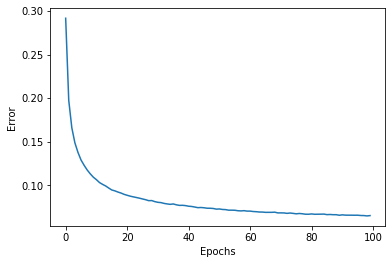

In [5]:
rbm1 = RBM(vis_unit = 100, hidd_unit=80)
model = rbm1.learn(training_data=new_data_train, learning_rate=0.01,epochs=100, CD_k=1, batch_size=50)

plt.plot(np.arange(100), rbm1.error_history)
plt.xlabel("Epochs")
plt.ylabel("Error")